# Movie Recommendation System

### Import and Load Data

In [1]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('tmdb_5000_credits.csv')
df2=pd.read_csv('tmdb_5000_movies.csv')

### Merge Data

In [2]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


### Number of Movies by Genre

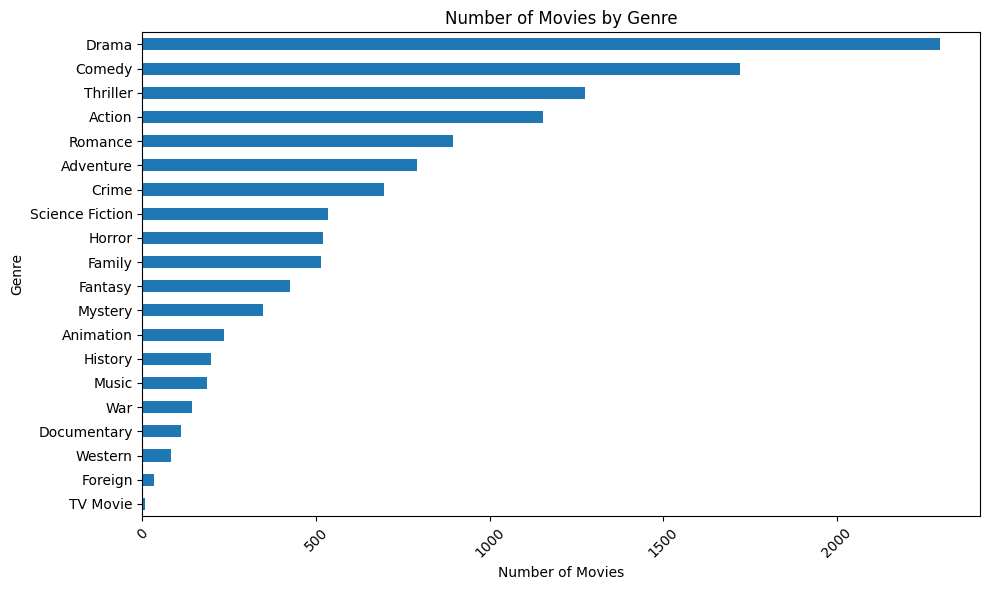

In [3]:
import matplotlib.pyplot as plt
import json

# Function to parse the genres column
def parse_genres(genres_str):
    try:
        genres = json.loads(genres_str.replace('\'', '\"'))
        return [g['name'] for g in genres]
    except json.JSONDecodeError:
        return []

df2['parsed_genres'] = df2['genres'].apply(parse_genres)

# Count the occurrence of each genre
genre_counts = df2['parsed_genres'].explode().value_counts()

# Plotting the distribution of genres
plt.figure(figsize=(10, 6))  
genre_counts.plot(kind='barh')  
plt.title('Number of Movies by Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().invert_yaxis()  
plt.show()

### Most Common Keywords

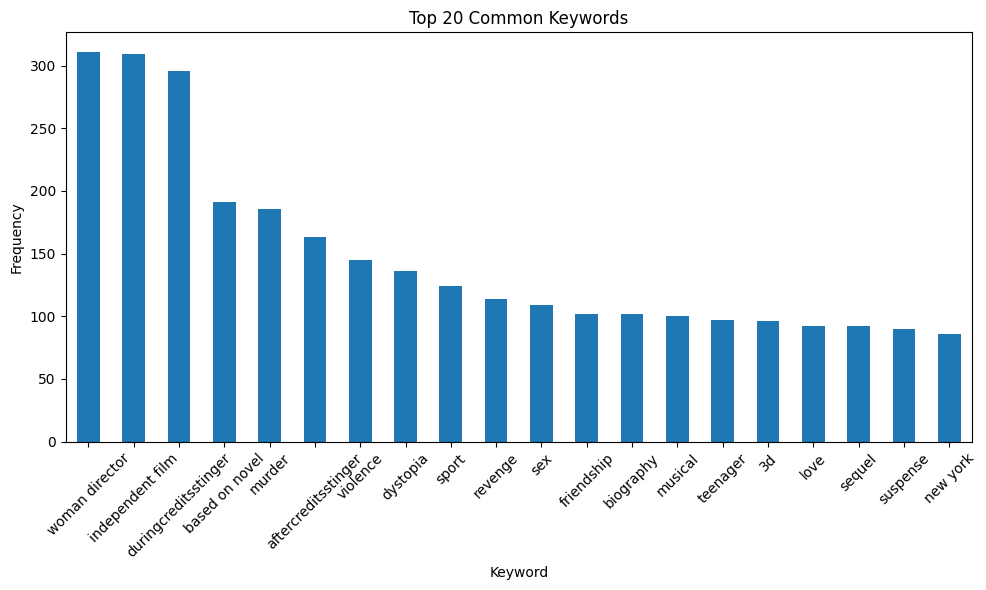

In [4]:
def parse_keywords(keywords_str):
    try:
        return [k['name'] for k in json.loads(keywords_str.replace('\'', '\"'))]
    except json.JSONDecodeError as e:
        return []

df2['parsed_keywords'] = df2['keywords'].apply(parse_keywords)

# Count the occurrence of each keyword
keyword_counts = df2['parsed_keywords'].explode().value_counts().head(20)  

# Plotting the most common keywords
plt.figure(figsize=(10, 6))
keyword_counts.plot(kind='bar')
plt.title('Top 20 Common Keywords')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Get Recommendations Function

In [5]:
## Utilizes linear_kernel, cosine similarity matrix

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
df2['overview'] = df2['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(df2['overview'])

from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    
    recommended_movies = df2['title'].iloc[movie_indices]
    similarity_scores = [i[1] for i in sim_scores]
    
    result_df = pd.DataFrame({'Movie': recommended_movies, 'Similarity Score': similarity_scores})
    
    return result_df

### Credits, Genres and Keywords Based Recommender

In [6]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']

def safe_literal_eval(s):
    if isinstance(s, (list, dict)):
        return s
    try:
        return literal_eval(s)
    except ValueError:
        try:
            if isinstance(s, str):
                s = s.replace('\'', '\"')
            return json.loads(s)
        except json.JSONDecodeError:
            return [] 

for feature in features:
    df2[feature] = df2[feature].apply(safe_literal_eval)

In [7]:
def get_director(x):
    for crew_member in x:
        if crew_member['job'] == 'Director':
            return crew_member['name']
    return np.nan

In [8]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    
    return []

In [9]:
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [10]:
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


In [11]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [12]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [13]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

df2['soup'] = df2.apply(create_soup, axis=1)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

## > GET RECOMMENDATIONS FUNCTION CALL

In [17]:
get_recommendations('The Godfather', cosine_sim2)

,Movie,Similarity Score
1990,The Empire Strikes Back,0.700000
1490,Return of the Jedi,0.600000
229,Star Wars: Episode III - Revenge of the Sith,0.400000
230,Star Wars: Episode II - Attack of the Clones,0.400000
233,Star Wars: Episode I - The Phantom Menace,0.400000
260,Ender's Game,0.400000
4401,The Helix... Loaded,0.365148
83,The Lovers,0.358569
193,After Earth,0.335410
4117,Six-String Samurai,0.335410
